# 1.BUSINESS UNDERSTANDING
    A. INTRODUCTION
In today's digital era, the world of cinema has witnessed a transformative shift. Streaming platforms have unlocked a vast library of movies, granting users unprecedented access to a multitude of entertainment options. However, amidst this abundance, users often find themselves overwhelmed, struggling to identify movies that resonate with their individual tastes. In response to this challenge, I introduce an innovative movie recommendation system, poised to revolutionize the way users discover and enjoy films.

    B.PROBLEM STATEMENT
The proliferation of online streaming platforms has created an ocean of cinematic choices, leaving users adrift in the quest for their next movie night selection. Navigating this vast sea of options can be daunting and time-consuming, often resulting in decision fatigue and missed opportunities to explore content aligned with one's preferences. My project seeks to address this issue by crafting a sophisticated movie recommendation system capable of leveraging user data and machine learning to deliver personalized movie suggestions. It aims to tackle the challenge of guiding users toward enjoyable movie choices, even for those who are new to the platform or movies with limited ratings.

    C.MAIN OBJECTIVE
To create a movie recommendation system that suggests the top 5 movies to users based on their ratings of other movies.

    D.SPECIFIC OBJECTIVES

# 2.IMPORTING LIBRARIES

In [212]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# 3.LOADING THE DATA

In [213]:
#loading data on movies.csv
movie_data = pd.read_csv('Datasets/movies.csv')
movie_data.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [214]:
#loading data on ratings.csv
rating_data = pd.read_csv('Datasets/ratings.csv')
rating_data.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


# 4.DATA CLEANING


In [215]:
movie_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [216]:
rating_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


From the above, the datasets do not contain any missing values.

### 4.1. DROPPING COLUMNS

Only a few features and rows from the various datasets that were gathered are important to the procedure. As a result, in this stage, the features from each dataset that were not necessary were removed. 

In [217]:
rating_data = rating_data.drop(columns=['timestamp'])
rating_data.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


### 4.2. ENCODING (ONE-HOT ENCODING)

In [218]:
# Convert genres into binary columns
#genres = movie_data['genres'].str.get_dummies('|')

# Concatenate the binary genre columns to the movie_data DataFrame
#movie_data = pd.concat([movie_data, genres], axis=1)

# Drop the original 'genres' column
#movie_data = movie_data.drop(columns=['genres'])
#movie_data.head()

# 5.EXPLORATORY DATA ANALYSIS

### 5.1. DATA VISUALIZATIONS

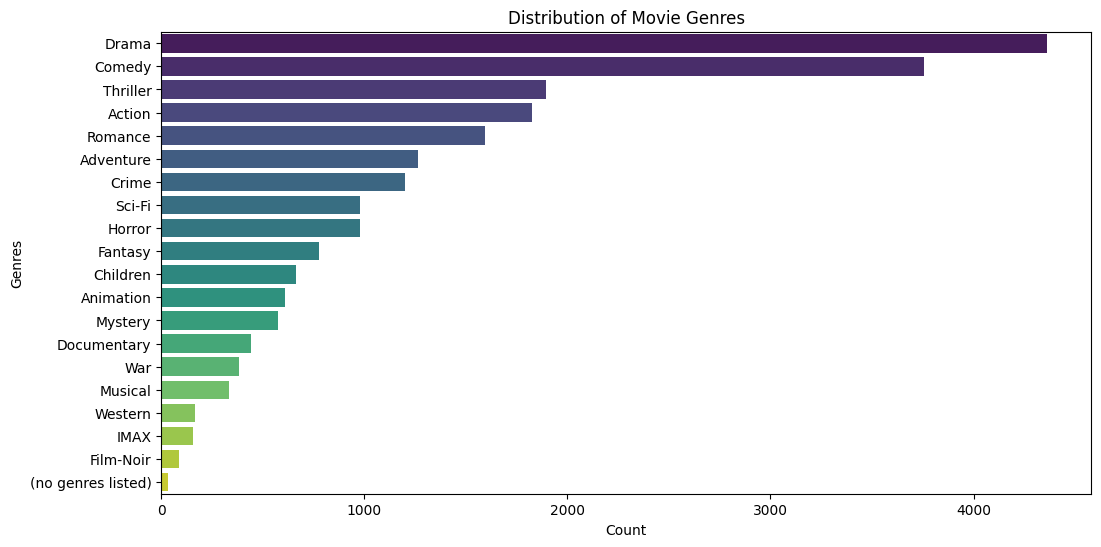

In [232]:
#Plot the distribution of movie genres
genre_counts = movie_data['genres'].str.split('|', expand=True).stack().value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette="viridis")
plt.title('Distribution of Movie Genres')
plt.xlabel('Count')
plt.ylabel('Genres')
plt.show()

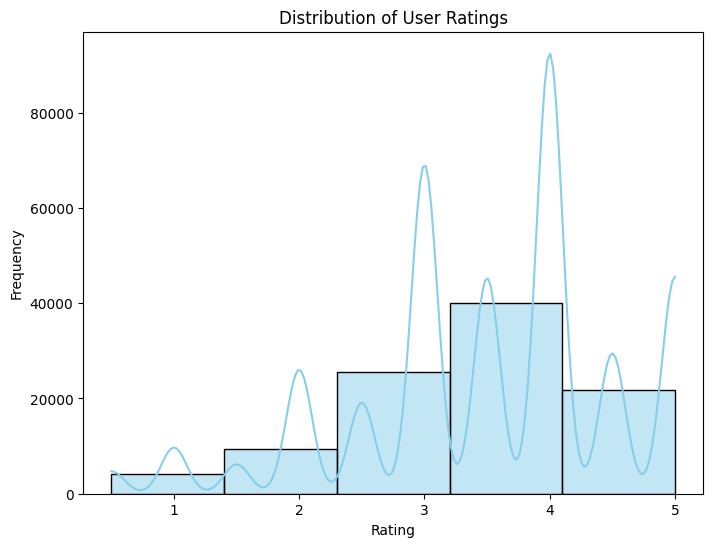

In [233]:
#Plot the distribution of user ratings
plt.figure(figsize=(8, 6))
sns.histplot(rating_data['rating'], bins=5, kde=True, color='skyblue')
plt.title('Distribution of User Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

# 5.EXPLORATORY DATA ANALYSIS
###     5.1.MERGE THE DATASETS

In [219]:
# Merge the ratings dataset with the movies dataset based on 'movieId'
merged_data = pd.merge(rating_data, movie_data, on='movieId')
merged_data

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...
100831,610,160341,2.5,Bloodmoon (1997),Action|Thriller
100832,610,160527,4.5,Sympathy for the Underdog (1971),Action|Crime|Drama
100833,610,160836,3.0,Hazard (2005),Action|Drama|Thriller
100834,610,163937,3.5,Blair Witch (2016),Horror|Thriller


###     5.2.CREATE USER-ITEM RATING MATRIX
After merging,  I created the user-item rating matrix. This matrix will have users as rows, movies as columns, and user ratings as values.The resulting user_item_matrix will be the basis for collaborative filtering, enabling me to make recommendations based on user-item interactions.

In [220]:
user_item_matrix = merged_data.pivot_table(index='userId', columns='movieId', values='rating')
print(user_item_matrix)


movieId  1       2       3       4       5       6       7       8        
userId                                                                    
1           4.0     NaN     4.0     NaN     NaN     4.0     NaN     NaN  \
2           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
5           4.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
...         ...     ...     ...     ...     ...     ...     ...     ...   
606         2.5     NaN     NaN     NaN     NaN     NaN     2.5     NaN   
607         4.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
608         2.5     2.0     2.0     NaN     NaN     NaN     NaN     NaN   
609         3.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
610         5.0     NaN     NaN     NaN     NaN     5.0     NaN     NaN   

movieId  9       10     

In [221]:
# Calculate the mean of each column (movie)
column_means = user_item_matrix.mean()

# Fill missing values in each column with the respective column mean
user_item_matrix_filled = user_item_matrix.fillna(column_means)

# Check the resulting user_item_matrix with missing values filled by column mean
print(user_item_matrix_filled)


movieId   1         2         3         4         5         6         7        
userId                                                                         
1        4.00000  3.431818  4.000000  2.357143  3.071429  4.000000  3.185185  \
2        3.92093  3.431818  3.259615  2.357143  3.071429  3.946078  3.185185   
3        3.92093  3.431818  3.259615  2.357143  3.071429  3.946078  3.185185   
4        3.92093  3.431818  3.259615  2.357143  3.071429  3.946078  3.185185   
5        4.00000  3.431818  3.259615  2.357143  3.071429  3.946078  3.185185   
...          ...       ...       ...       ...       ...       ...       ...   
606      2.50000  3.431818  3.259615  2.357143  3.071429  3.946078  2.500000   
607      4.00000  3.431818  3.259615  2.357143  3.071429  3.946078  3.185185   
608      2.50000  2.000000  2.000000  2.357143  3.071429  3.946078  3.185185   
609      3.00000  3.431818  3.259615  2.357143  3.071429  3.946078  3.185185   
610      5.00000  3.431818  3.259615  2.

In [222]:
# Get the transpose of the user_item_matrix_filled
user_item_matrix_transpose = user_item_matrix_filled.T

# Check the resulting transpose matrix
print(user_item_matrix_transpose)


userId        1         2         3         4         5        6         7     
movieId                                                                        
1        4.000000  3.920930  3.920930  3.920930  4.000000  3.92093  4.500000  \
2        3.431818  3.431818  3.431818  3.431818  3.431818  4.00000  3.431818   
3        4.000000  3.259615  3.259615  3.259615  3.259615  5.00000  3.259615   
4        2.357143  2.357143  2.357143  2.357143  2.357143  3.00000  2.357143   
5        3.071429  3.071429  3.071429  3.071429  3.071429  5.00000  3.071429   
...           ...       ...       ...       ...       ...      ...       ...   
193581   4.000000  4.000000  4.000000  4.000000  4.000000  4.00000  4.000000   
193583   3.500000  3.500000  3.500000  3.500000  3.500000  3.50000  3.500000   
193585   3.500000  3.500000  3.500000  3.500000  3.500000  3.50000  3.500000   
193587   3.500000  3.500000  3.500000  3.500000  3.500000  3.50000  3.500000   
193609   4.000000  4.000000  4.000000  4

In [223]:
# Calculate the correlation matrix for the transposed user_item_matrix
correlation_matrix = user_item_matrix_transpose.corr()

# Check the resulting correlation matrix
print(correlation_matrix)


userId       1         2         3         4         5         6         7     
userId                                                                         
1       1.000000  0.981361  0.968064  0.961786  0.980270  0.967982  0.968921  \
2       0.981361  1.000000  0.985716  0.977565  0.996879  0.984176  0.985635   
3       0.968064  0.985716  1.000000  0.965311  0.984030  0.972688  0.973500   
4       0.961786  0.977565  0.965311  1.000000  0.975613  0.964872  0.967989   
5       0.980270  0.996879  0.984030  0.975613  1.000000  0.982943  0.984312   
...          ...       ...       ...       ...       ...       ...       ...   
606     0.958755  0.976107  0.962140  0.955285  0.974750  0.961633  0.962864   
607     0.970771  0.986096  0.974160  0.966672  0.984900  0.974062  0.974946   
608     0.933873  0.954604  0.943196  0.933437  0.952844  0.936647  0.940332   
609     0.981666  0.998366  0.986072  0.978144  0.997267  0.984419  0.985857   
610     0.953530  0.968538  0.957117  0.

In [224]:
# Find the 3rd user (User ID 3) in the correlation matrix
user_5_correlations = correlation_matrix.iloc[4]  # Index 4 corresponds to User ID 5

# Sort the correlations in descending order and drop null values
top_100_correlations = user_5_correlations.sort_values(ascending=False).dropna().head(100)

# Print the top 100 correlated users with User 5
print("Top 100 Correlated Users with User 5:")
print(top_100_correlations)


Top 100 Correlated Users with User 5:
userId
5      1.000000
145    0.997843
189    0.997581
49     0.997492
26     0.997389
         ...   
248    0.996194
540    0.996190
252    0.996168
531    0.996166
37     0.996164
Name: 5, Length: 100, dtype: float64


In [225]:
# Check if User 5 rated Movie 6
user_id = 5
movie_id = 6

# Get the rating from the user-item matrix
rating = user_item_matrix_filled.loc[user_id, movie_id]

if not np.isnan(rating):
    print(f"User {user_id} rated Movie {movie_id} with a rating of {rating}")
else:
    print(f"User {user_id} did not rate Movie {movie_id}")


User 5 rated Movie 6 with a rating of 3.946078431372549


In [226]:
# Get the top 100 users based on correlation
top100_users = top_100_correlations.keys()

# Initialize a counter and a list to store users who have rated movie 6
count = 0
users = list()

# Iterate through the top 100 users
for user in top100_users:
    # Filter the DataFrame to find rows where the user rated Movie 6
    user_movie6_ratings = merged_data[(merged_data['userId'] == user) & (merged_data['movieId'] == 6)]
    
    # Check if the user has any ratings for Movie 6
    if not user_movie6_ratings.empty:
        count += 1
        users.append(user)

# Print the count of users who have rated Movie 6 in the top 100 correlated users
print(f"Number of users in the top 100 correlated users who have rated movie 6: {count}")


Number of users in the top 100 correlated users who have rated movie 6: 6


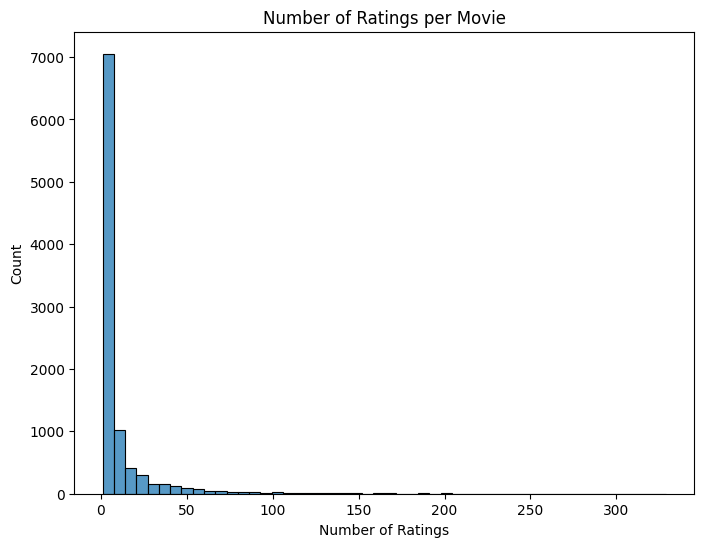

In [228]:
# Number of ratings per movie
movie_ratings_count = merged_data.groupby('movieId')['rating'].count()
plt.figure(figsize=(8, 6))
sns.histplot(movie_ratings_count, bins=50)
plt.title('Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Count')
plt.show()


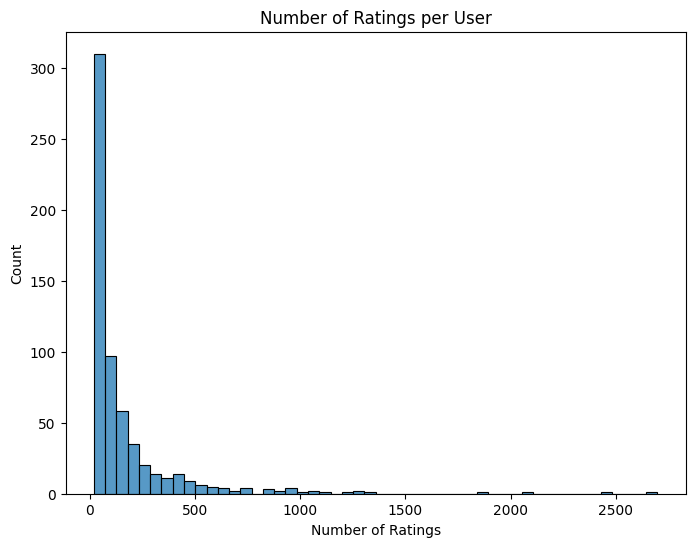

In [229]:
# Number of ratings per user
user_ratings_count = rating_data.groupby('userId')['rating'].count()
plt.figure(figsize=(8, 6))
sns.histplot(user_ratings_count, bins=50)
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Count')
plt.show()

In [230]:
# Top-rated movies
top_rated_movies = merged_data.groupby('movieId')['rating'].mean().sort_values(ascending=False)
top_rated_movies = pd.merge(top_rated_movies, merged_data[['movieId', 'title']], on='movieId', how='left')
top_rated_movies = top_rated_movies.drop_duplicates(subset=['movieId', 'title'])
top_rated_movies = top_rated_movies.head(10)
print("Top-rated movies:")
print(top_rated_movies)

Top-rated movies:
   movieId  rating                                      title
0    88448     5.0      Paper Birds (Pájaros de papel) (2010)
1   100556     5.0                 Act of Killing, The (2012)
2   143031     5.0                            Jump In! (2007)
3   143511     5.0                               Human (2015)
4   143559     5.0                        L.A. Slasher (2015)
5     6201     5.0                           Lady Jane (1986)
6   102217     5.0             Bill Hicks: Revelations (1993)
7   102084     5.0               Justice League: Doom (2012) 
8     6192     5.0  Open Hearts (Elsker dig for evigt) (2002)
9   145994     5.0                     Formula of Love (1984)


# 6.RECOMMENDATION SYSTEM DEVELOPMENT

### 6.1.COLLABORATIVE FILTERING

In [ ]:
#Identify the top 100 correlated users with User 10
top_100_correlated_users = top_100_correlations.index.tolist()

#Filter movies that User 10 hasn't rated
user_5_ratings = user_item_matrix_filled.loc[4]  # Ratings of User 10
unrated_movies_user_5 = user_5_ratings[user_5_ratings.isnull()].index.tolist()

print(f"Number of unrated movies for User 10: {len(unrated_movies_user_5)}")

#Generate movie recommendations for User 10
movie_recommendations = []
for movie_id in unrated_movies_user_5:
    weighted_sum = 0
    similarity_sum = 0
    for user_id in top_100_correlated_users:
        user_similarity = top_100_correlations[user_id]
        user_rating = user_item_matrix_filled.loc[user_id, movie_id]
        if not np.isnan(user_rating):
            weighted_sum += user_similarity * user_rating
            similarity_sum += abs(user_similarity)
    if similarity_sum > 0:
        predicted_rating = weighted_sum / similarity_sum
        movie_recommendations.append((movie_id, predicted_rating))

print(f"Number of movie recommendations for User 5:{len(movie_recommendations)}")

#Sort recommendations by predicted rating in descending order
movie_recommendations.sort(key=lambda x: x[1], reverse=True)

#Print the top 10 movie recommendations
top_10_recommendations = movie_recommendations[:10]
for movie_id, predicted_rating in top_10_recommendations:
    movie_title = movie_data[movie_data['movieId'] == movie_id]['title'].values[0]
    print(f"Movie: {movie_title}, Predicted Rating: {predicted_rating:.2f}")


Number of unrated movies for User 10: 0
Number of movie recommendations for User 5:0


user-item matrix get transpose
2.get corelation of user ittem matrix transpose
3.select a random user from the transpose matrix and drop null values in that user

sort the correlation of the user...
look at the top 100 co-related to user 1(1-100)



check userrrrr 4 rated movieid 6,merged df{}
based on the correlation, user 5 will rate how this movie....moviedf['title][]......
....predict..how user will rate movie no ......(weighted ratings)
df for mean ratings.....
from mean ratings ...total ratings column
....
no of people who rated a particular movie
create a fxn to calcullate how user 5 willl rate movie 6




merged data
word_cloud.......genre column create a dictionary 
top watched movie:heavily rated movie....
highly rated movies
mean rating ...and total ratings relationship

